Start this on the zedboard first
```bash
$ sudo python3 litex_server.py --devmem --devmem-offset 0x40000000
```

In [1]:
%pylab notebook
from struct import pack, unpack
import time
import sys
sys.path.append("../..")
from common import *
from scope_app import autoBitslip, autoIdelay

Populating the interactive namespace from numpy and matplotlib


# Setup SPI, reset and dump LTC2175 registers

In [2]:
r = conLitexServer('../build/csr.csv')
print("f_sample:", r.regs.lvds_f_sample_value.read() / 1e6, "MHz")

ltc_spi = LTC_SPI(r)
for i in range(5):
    print("{:2x}: {:02x}".format(i, ltc_spi.get_ltc_reg(i)))

ltc_spi.set_ltc_reg(0, 0x80)   # Software reset
# ltc_spi.set_ltc_reg(1, 0x10)   # Sleep mode
# ltc_spi.set_ltc_reg(1, 0x00)   # Waky waky

ltc_spi.setTp(1)
autoBitslip(r)
autoIdelay(r)

Connected to Port 1234
LTC2175 demonstrator 2019-09-16 17:04:30
f_sample: 125.000576 MHz
 0: 00
 1: 03
 2: 08
 3: 02
 4: 00
autoBitslip(): aligned after 0
autoIdelay(): min = 6, mean = 12, max = 19 idelays


# Play with bitslip / idelay parameters

### show status

In [3]:
def print_frm():
    idel = r.regs.lvds_idelay_value.read()
    v = r.regs.lvds_frame_peek.read()
    print("ID: {:}  F: {:08b}".format(idel, v))
    for i in range(4):
        v = getattr(r.regs, 'lvds_data_peek{:}'.format(i)).read()
        print("{:}: {:016b}".format(i, v))
ltc_spi.setTp(1)
print_frm()

ID: 12  F: 11110000
0: 0000000000000100
1: 0000000000000100
2: 0000000000000100
3: 0000000000000100


### bitslip until we get 0xF0 on frame_peek

In [113]:
r.regs.lvds_bitslip_csr.write(1)
print_frm()

ID: 13  F: 11110000
0: 0000000000000100
1: 0000000000000100
2: 0000000000000100
3: 0000000000000100


### IDELAY adjustments to find the eye limits

In [10]:
r.regs.lvds_idelay_inc.write(1)
print_frm()

ID: 19  F: 11110000
0: 0000000000010000
1: 0000000000000000
2: 0000000000000000
3: 0000000000000100


In [22]:
r.regs.lvds_idelay_dec.write(1)
print_frm()

ID: 7  F: 01111000
0: 0000000000000100
1: 0000000000000100
2: 0000000000000100
3: 0000000000000001


do a bitslip until we get 0x0F

### map data lanes
Check that each bit in the test-pattern end up in the right place in the output word

In [4]:
for ch in range(4):
    print("Channel {:d}".format(ch))
    for i in range(14):
        tpValue = 1 << i
        ltc_spi.setTp(tpValue)
        rVal = getattr(r.regs, 'lvds_data_peek{:d}'.format(ch)).read()
        print("{:016b} {:016b}".format(tpValue, rVal))    

Channel 0
0000000000000001 0000000000000100
0000000000000010 0000000000001000
0000000000000100 0000000000010000
0000000000001000 0000000000100000
0000000000010000 0000000001000000
0000000000100000 0000000010000000
0000000001000000 0000000100000000
0000000010000000 0000001000000000
0000000100000000 0000010000000000
0000001000000000 0000100000000000
0000010000000000 0001000000000000
0000100000000000 0010000000000000
0001000000000000 0100000000000000
0010000000000000 1000000000000000
Channel 1
0000000000000001 0000000000000100
0000000000000010 0000000000001000
0000000000000100 0000000000010000
0000000000001000 0000000000100000
0000000000010000 0000000001000000
0000000000100000 0000000010000000
0000000001000000 0000000100000000
0000000010000000 0000001000000000
0000000100000000 0000010000000000
0000001000000000 0000100000000000
0000010000000000 0001000000000000
0000100000000000 0010000000000000
0001000000000000 0100000000000000
0010000000000000 1000000000000000
Channel 2
0000000000000001 0

# Read ADC sample

In [4]:
ltc_spi.set_ltc_reg(3, 0)   # Test pattern off
ltc_spi.set_ltc_reg(1, 0)   # Randomizer off

In [112]:
# Lowest 2 bits are always zero in 16 bit LVDS mode
# 12 bit ADC, so next 2 bits are also zero
rVal = r.regs.lvds_data_peek0.read()
print("0x{0:03x} 0b{0:012b}".format(rVal))
# Decode offset binary mode
print((rVal - 0x8000) >> 4)

0x8400 0b1000010000000000
64


In [88]:
r.regs.acq_trig_level.write((64 << 4) + (1 << 15))

In [111]:
r.regs.acq_trig_csr.read()

0

In [108]:
r.regs.acq_trig_csr.write(0)

# Read randomized ADC sample

In [ ]:
ltc_spi.set_ltc_reg(1, (1<<6))   # Randomizer on

In [ ]:
rVal = r.regs.lvds_data_peek.read() >> 4
print("0x{0:03x} 0b{0:012b}".format(rVal))
# XOR LSB with any other bit
if rVal & 0x01:
    rVal ^= 0xFFE
# Decode offset binary mode
print(rVal - (1 << 11))

# Read acquisition memory

In [149]:
r.regs.acq_trig_level.write((5 << 4) + (1 << 15))
print(hex(r.regs.acq_trig_level.read()))
r.regs.acq_trig_csr.write(1)

0x8050


In [77]:
hd(r.big_read(0x10000000, 0x400), 2, 1)


0000: c000 c000 c000 c000 c000 c000 c000 c000 
0008: c000 c000 c000 c000 c000 c000 c000 c000 
0010: c000 c000 c000 c000 c000 c000 c000 c000 
0018: c000 c000 c000 c000 c000 c000 c000 c000 
0020: c000 c000 c000 c000 c000 c000 c000 c000 
0028: c000 c000 c000 c000 c000 c000 c000 c000 
0030: c000 c000 c000 c000 c000 c000 c000 c000 
0038: c000 c000 c000 c000 c000 c000 c000 c000 
0040: c000 c000 c000 c000 c000 c000 c000 c000 
0048: c000 c000 c000 c000 c000 c000 c000 c000 
0050: c000 c000 c000 c000 c000 c000 c000 c000 
0058: c000 c000 c000 c000 c000 c000 c000 c000 
0060: c000 c000 c000 c000 c000 c000 c000 c000 
0068: c000 c000 c000 c000 c000 c000 c000 c000 
0070: c000 c000 c000 c000 c000 c000 c000 c000 
0078: c000 c000 c000 c000 c000 c000 c000 c000 
0080: c000 c000 c000 c000 c000 c000 c000 c000 
0088: c000 c000 c000 c000 c000 c000 c000 c000 
0090: c000 c000 c000 c000 c000 c000 c000 c000 
0098: c000 c000 c000 c000 c000 c000 c000 c000 
00a0: c000 c000 c000 c000 c000 c000 c000 c000 
00a8: c000 c

In [ ]:
r.mems.

In [ ]:
r.regs.acq_trig_channel

<IPython.core.display.Javascript object>


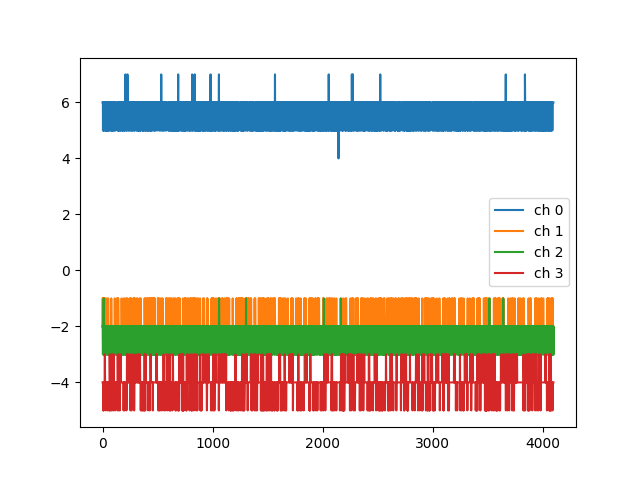

In [181]:
close('all')
for i in range(4):
    dat = array(r.big_read(0x10000000 + i * 0x01000000, 0x1000))
    dat = (dat - 0x8000) >> 4
    plot(dat, label='ch ' + str(i))
legend()

In [182]:
r.regs.ctrl_bus_errors.read()

0